In [3]:
import sys, time, cProfile, pstats, importlib, os, itertools
sys.path.insert(0,'/home/uq/apps/muq2inst/lib')
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 10.)
matplotlib.rcParams.update({'font.size': 22})

import pymuqUtilities as mu

import plotutil

from GaussianPosterior import GaussianPosterior
from DeepTransportMap import *


def plot_results(noise, x_multis, results_l2, results_st, results_et) :
    fig = plt.figure()
    fig.suptitle('noise = {}'.format(noise), fontsize=20)

    ax = plotutil.get_ax(fig, 3, 1, title='L2 error', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    ax.set_xticks(x_multis)
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_l2[i], axis=1), yerr=np.std(results_l2[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 2, title='setup time', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    ax.set_xticks(x_multis)
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_st[i], axis=1), yerr=np.std(results_st[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 3, title='eval time', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    ax.set_xticks(x_multis)
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_et[i], axis=1), yerr=np.std(results_et[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    plt.tight_layout()
    plt.show()

In [20]:
[mu.MultiIndexFactory.CreateAnisotropic([.42, .41], 1/(10**i)).Size() for i in range(1,15,3)]

[6, 66, 190, 371, 614]

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 8, 12, 16, 21, 25, 29]


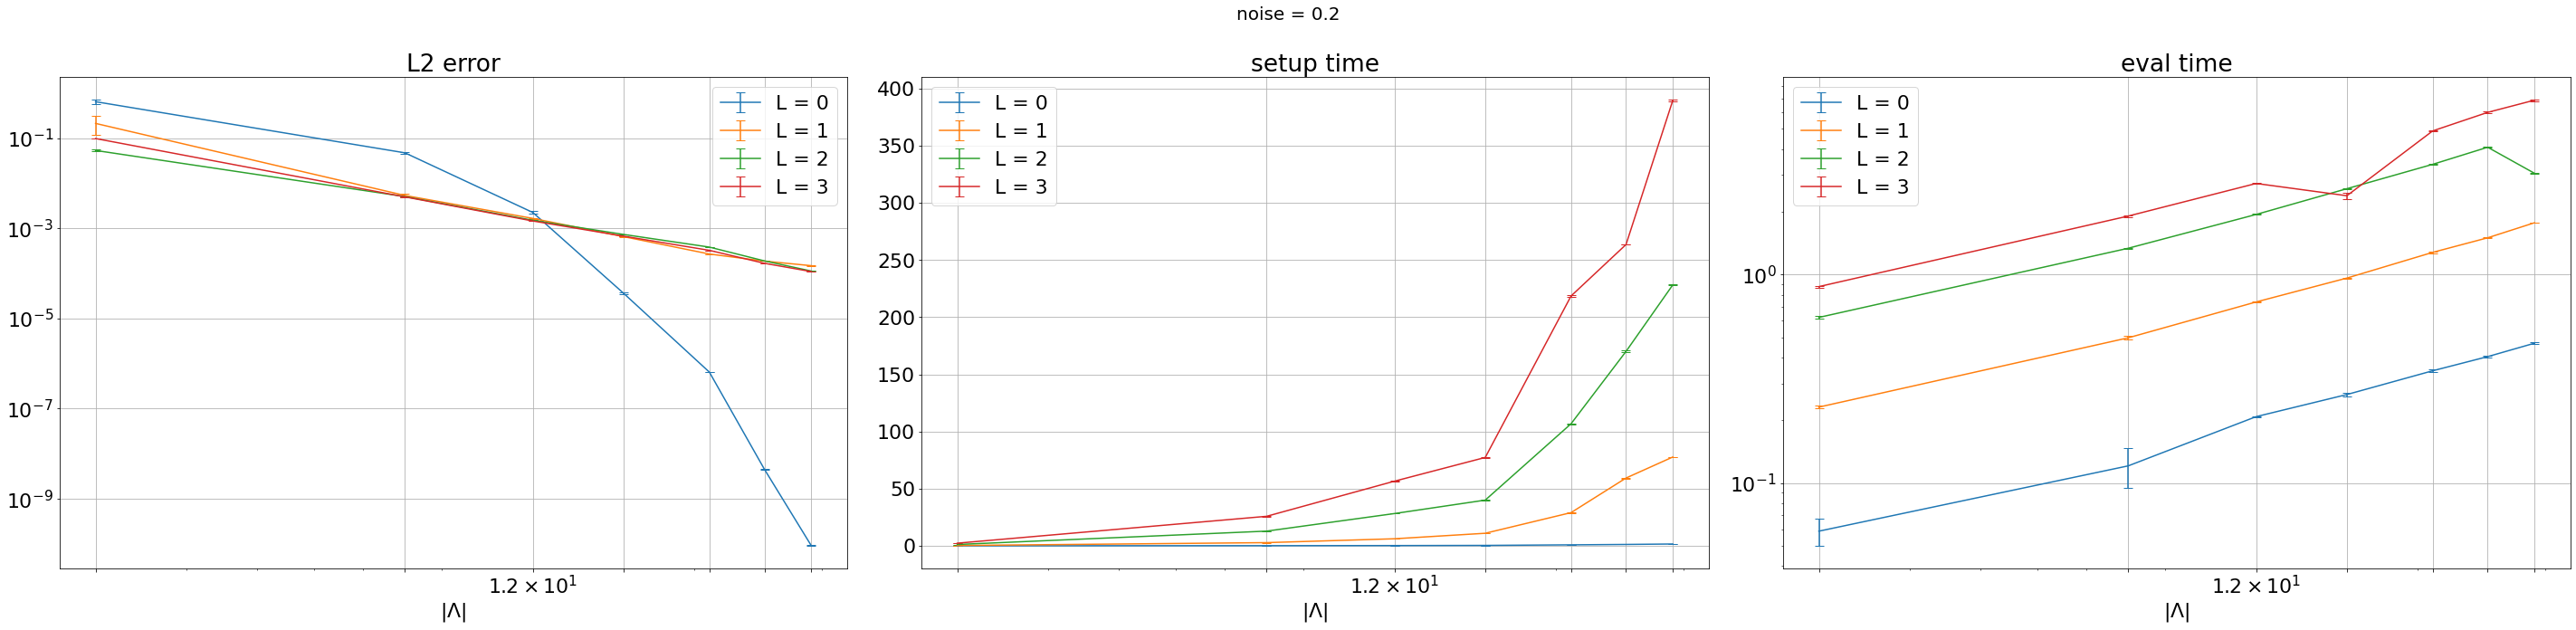

In [2]:
noise = .2
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,21,3)]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 8, 12, 16, 21, 25, 29]


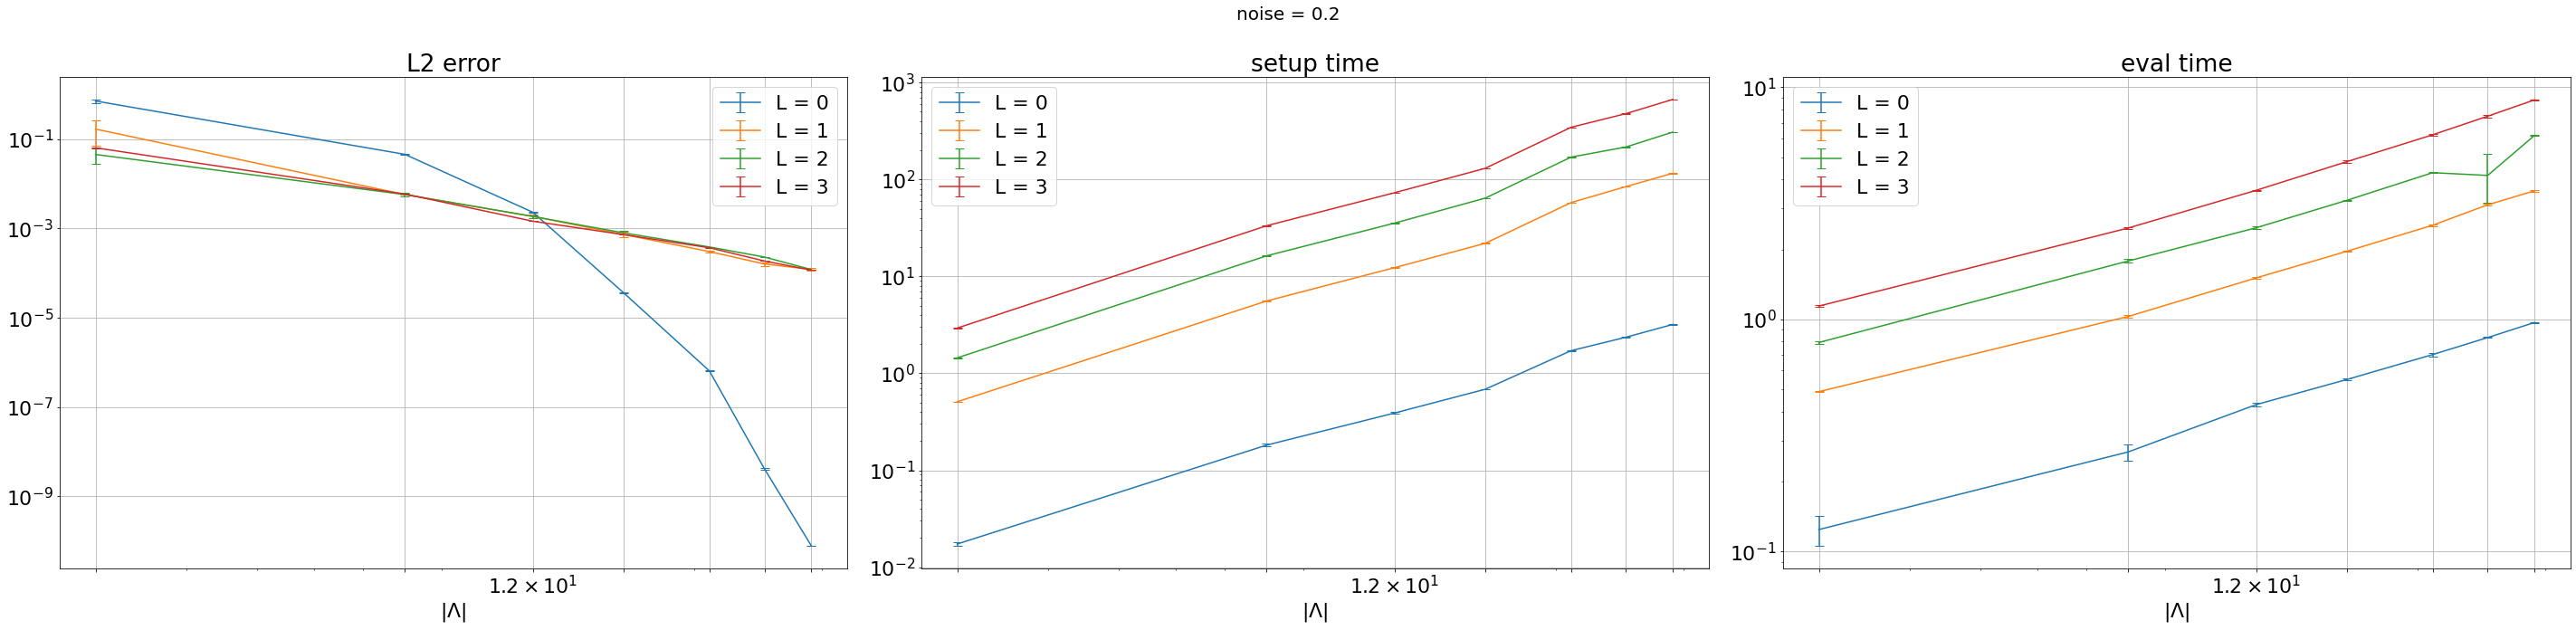

In [10]:
noise = .2
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,21,3)]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 8, 12, 16, 21, 25, 29]


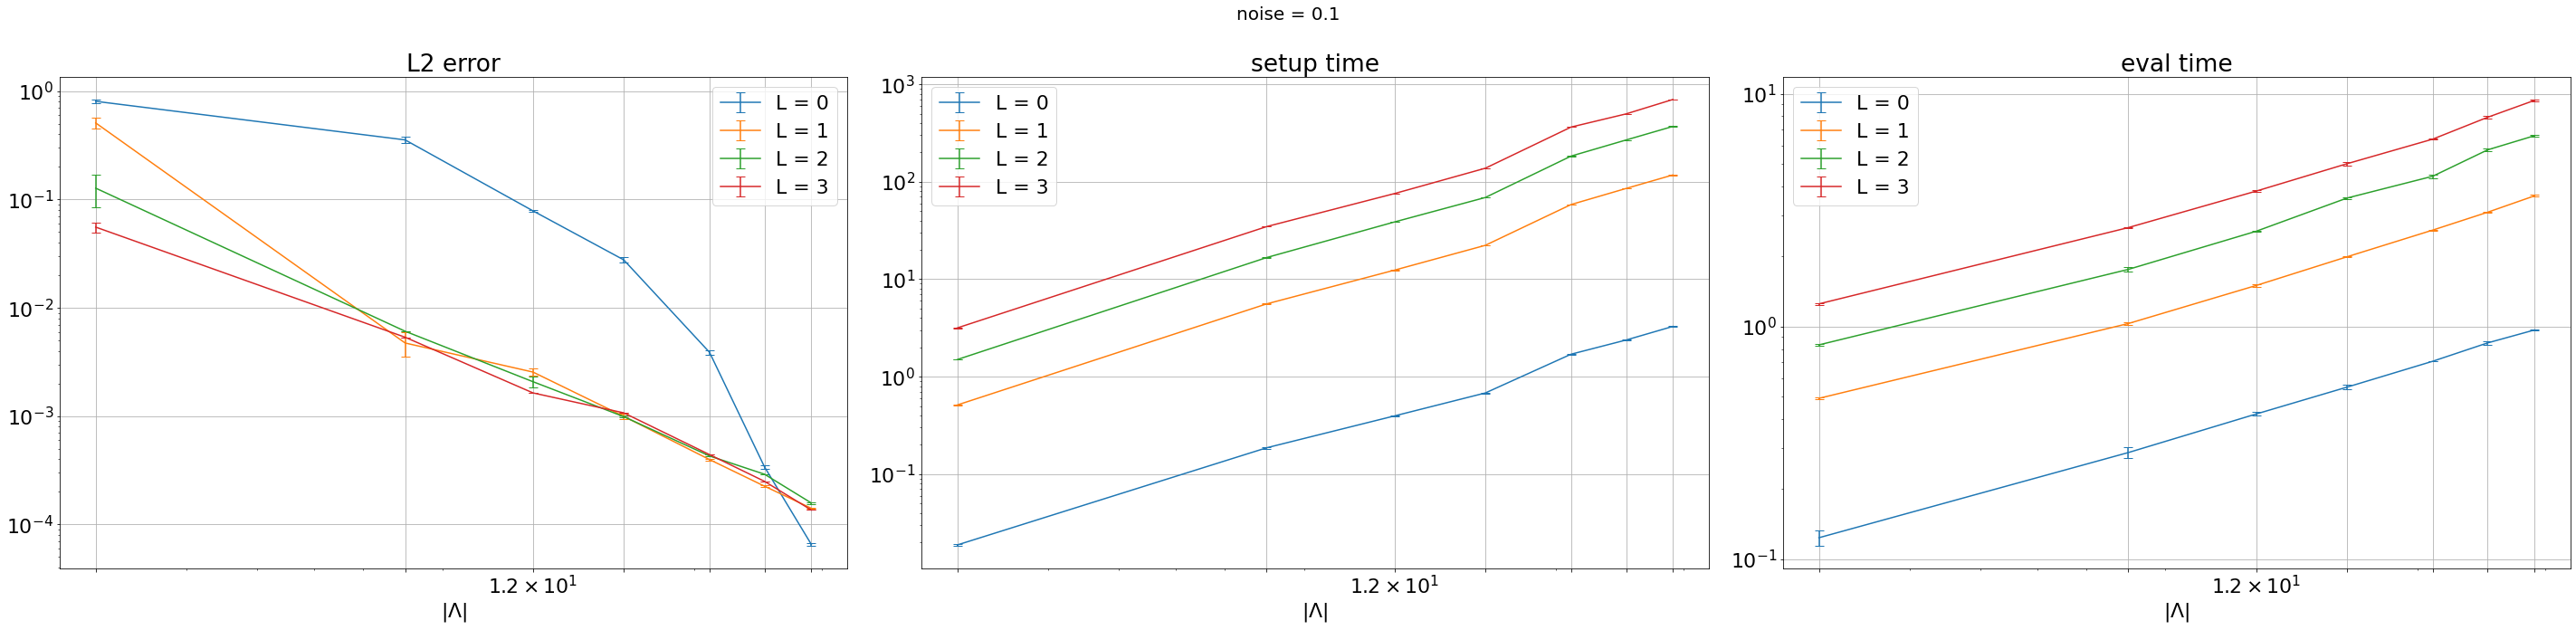

In [9]:
noise = .1
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,21,3)]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 8, 12, 16, 21, 25, 29]


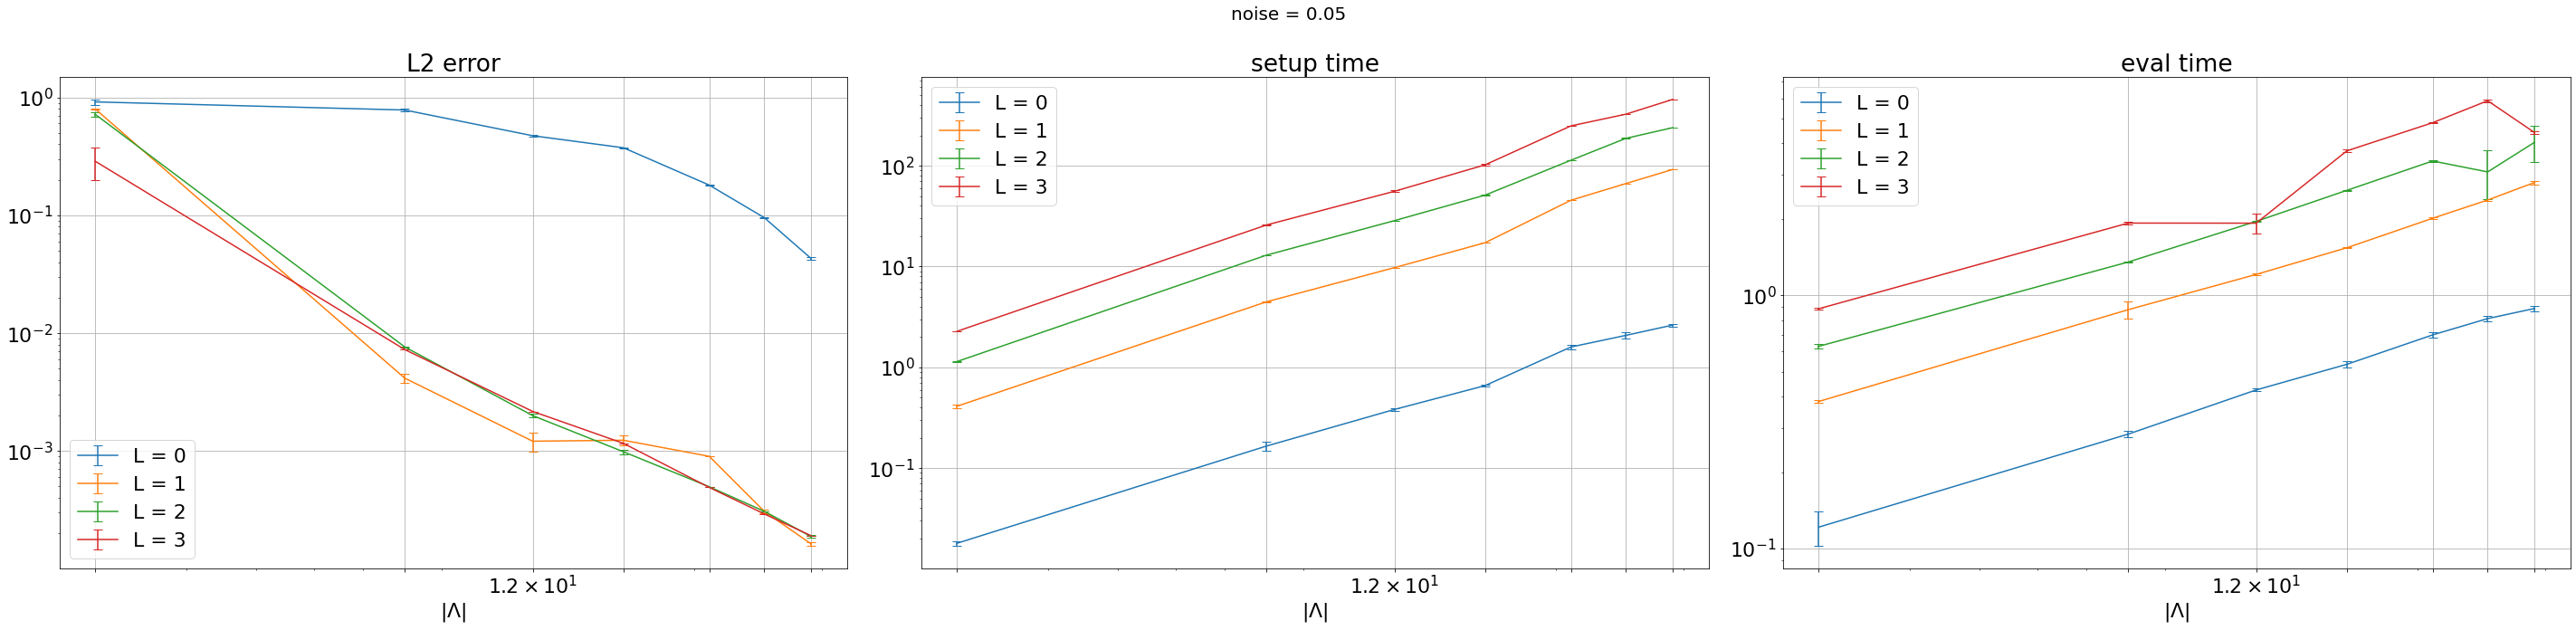

In [8]:
noise = .05
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,21,3)]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 6, 9, 12, 15, 18, 21, 23, 26, 29, 32, 35, 38, 41, 43]


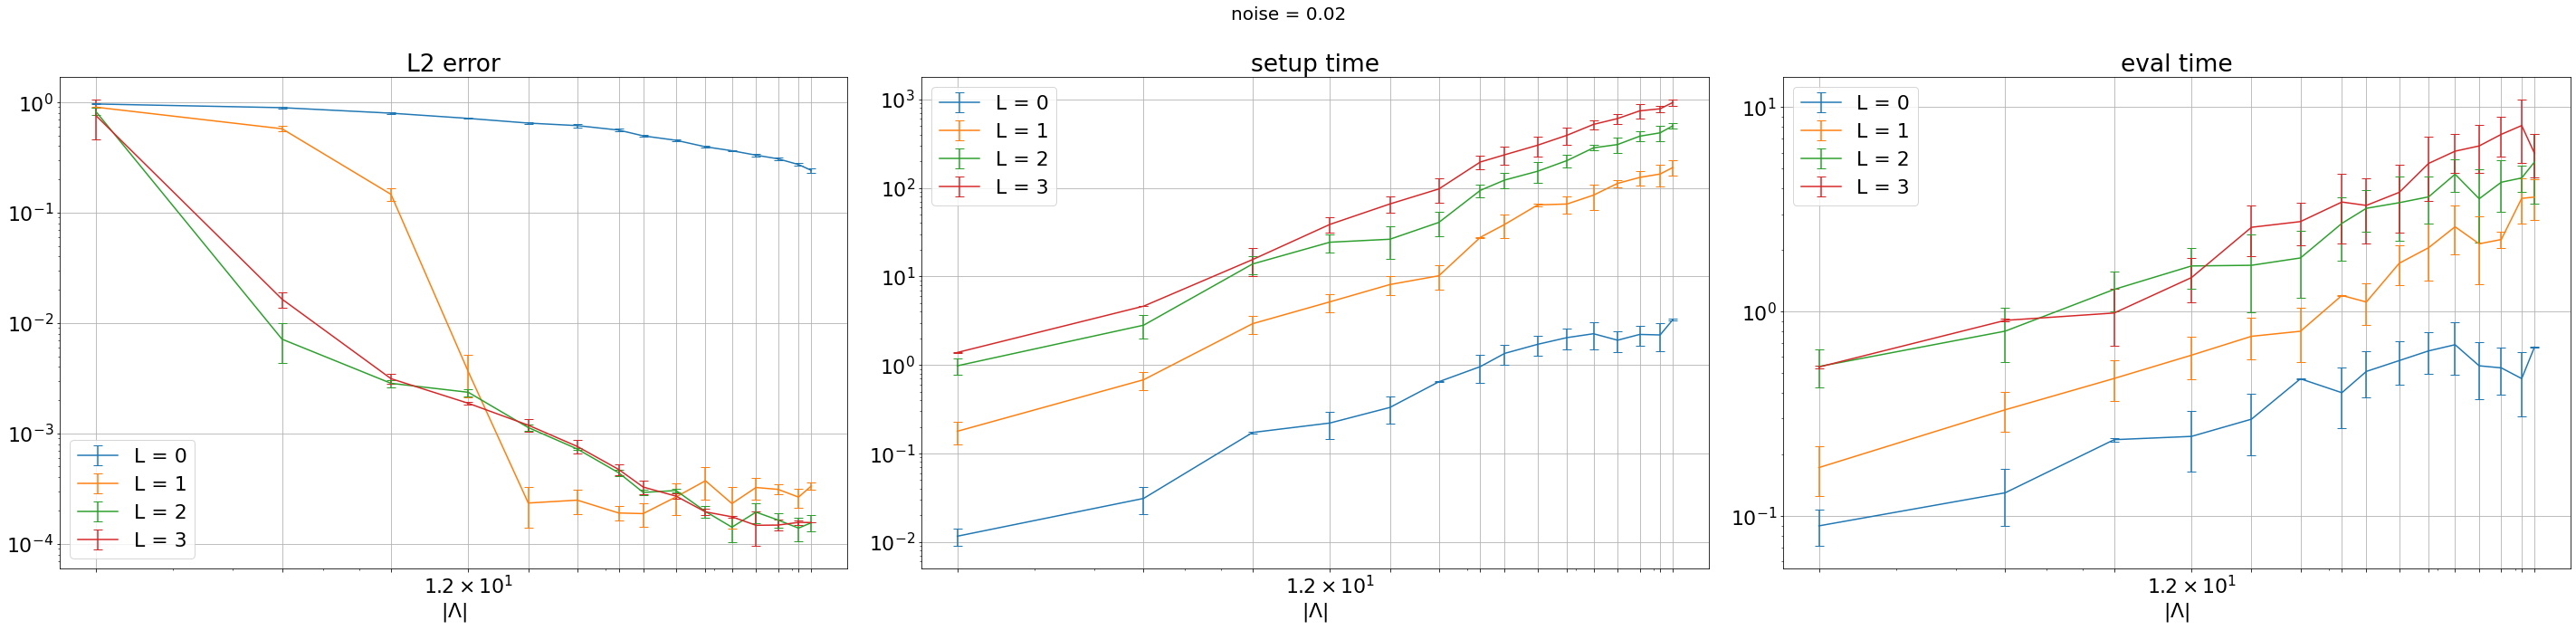

In [21]:
noise = .02
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,31,2)]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=7) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.5, 1], [0.25, 0.5, 1], [0.125, 0.25, 0.5, 1]]
x_multis: [3, 9, 15, 21, 26, 32, 38, 43]


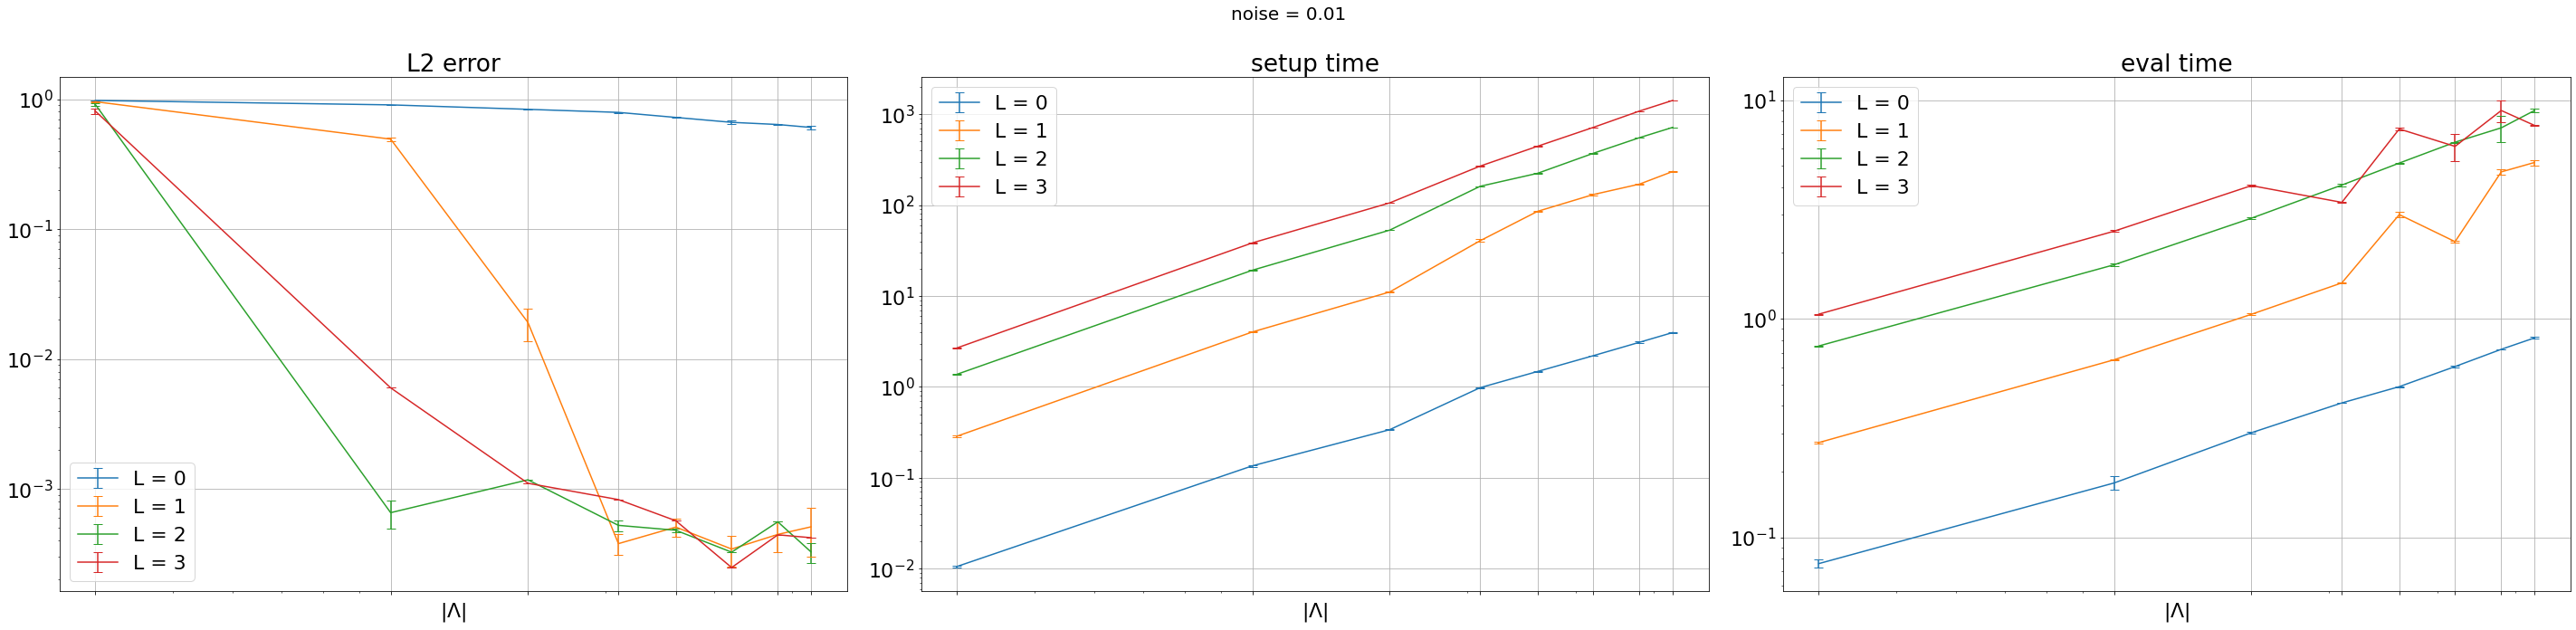

In [14]:
noise = .01
multis = [mu.MultiIndexFactory.CreateAnisotropic([.2], 1/(10**i)) for i in range(2,31,4)]
L_max = 4
n_runs = 4
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[2**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

In [23]:
import legendreutil as lu

multiset = mu.MultiIndexFactory.CreateAnisotropic([.6], .1)
print('Number of multi-indices : ', multiset.Size())

n = 100000
x = np.linspace(-1,1,n)
be = [lu.evaluate_basis(np.expand_dims([xi], axis=1), multiset) for xi in x]

print(be[0].shape)

for i in range(multiset.Size()) :
    for j in range(multiset.Size()) :
        prod = np.sum([be[k][0,i]*be[k][0,j] for k in range(len(x))])*2/n
        print('{:.4f}\t'.format(prod), end='')
    print()

Number of multi-indices :  5
(1, 5)
1.0000	0.0000	0.0000	-0.0000	0.0000	
0.0000	1.0000	-0.0000	0.0000	-0.0000	
0.0000	-0.0000	1.0000	-0.0000	0.0001	
-0.0000	0.0000	-0.0000	1.0001	-0.0000	
0.0000	-0.0000	0.0001	-0.0000	1.0001	
